<a href="https://colab.research.google.com/github/Deividasbu/Eleving-Group-Task/blob/main/Task_Deividas_Butkus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis of hypothetical car leasing company data using SQL  
### Requirements 

Please write SQL script for each question and comment:
1. How many applications are currently active?  
2. TOP 3 reasons for cancelling application.
3. What share of total applications do cars and motorcycles applications have? 
4. Which product(s) could be no longer used, why? 
5. How many loans each operator issued week over week? Any comments?
6. Please make a schedule on (calculate) how many repayments are expected for each month (assuming the client will pay according to his schedule).
7. Please graphically show change of loans issued daily (Excel).
8. Add any interesting findings from the data.  


---




### Applicant part

Given data is in excel format and the exercise is asking to analyse it using SQL, below the table is created and excel dataframe is inserted inside that table. It allows me to read table using SQL queries. 

In [14]:
import pandas as pd, csv, sqlite3

conn = sqlite3.connect('applications.db')
c = conn.cursor()
c.execute("""CREATE TABLE IF NOT EXISTS applications (
            application_id int,
            application_status text,
            product text,
            vehicle_type text,
            operator text,
            application_created datetime,
            loan_issued datetime,
            term_value int,
            term_unit text,
            cancellation_reason text,
            is_test int
            )""")
conn.commit()

df = pd.read_excel('task_analyst.xlsx')
df.to_sql('applications', conn, if_exists='append', index=False)

I also define some most used plotting functions in order to keep the notebook as clean as possible.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def bar_plot(x, y, df, title:str):

  plt.figure(figsize=(12, 6))
  
  splot = sns.barplot(x=x, y=y, data=df, palette='Blues')
  splot.bar_label(splot.containers[0])
  sns.set(style="whitegrid")
  plt.xlabel('')
  plt.ylabel('')
  plt.title(title, size=18, color='#4f4e4e', pad=14)
  plt.xticks(size=12, color='#4f4e4e')
  plt.yticks([], [])
  sns.despine(left=True)

Before diving into analysis I must check whether all applications are unique, because if application has several records when its status change, I should account that in my analysis. Below we can see that number of unique applications is equal to the number of total applications and it means each row corresponds to a unique application.

In [ ]:
unique_applications =  pd.read_sql('select distinct(application_id) from applications', conn)
all_applications = pd.read_sql('select count(*) from applications', conn)
assert len(unique_applications) == all_applications.iloc[0][0]

#### Question 1. How many applications are currently active?
Before trying to find how many applications are cancelled I want to check what status application can have. Below we can see that out of 9 different statuses, only one means true cancelation. Therefore for the further analysis I assume that application is active if its status is not "Cancelled". 

In [31]:
pd.read_sql("select distinct(application_status) from applications ", conn)

,application_status
0,Cancelled
1,Loan issued
2,Collect info/docs
3,Vehicle valuation
4,New
5,Install GPS
6,Prepare and sign agreement
7,Vehicle registration
8,Partial payment


Keeping that in mind I plot the number of active and cancelled applications below.

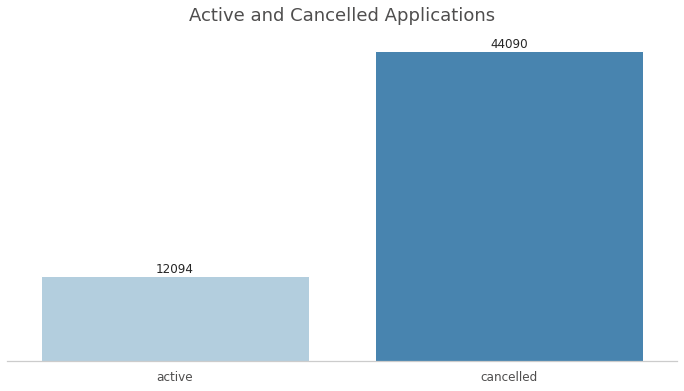

In [9]:
query = """
        select count(*) as number, 'active' as application_type 
        from applications
        where application_status  != 'Cancelled' 

        union all 

        select count(*) as number, 'cancelled' as application_type 
        from applications
        """
active = pd.read_sql(query, conn)
bar_plot(x='application_type', y='number', df=active, title='Active and Cancelled Applications')


We can see that majority of the applications are cancelled and less than one third are active.

#### Question 2. TOP 3 reasons for cancelling application.

In [5]:
query = """
        select cancellation_reason, count(*) number_of_applications
        from applications
        where cancellation_reason != 'None'
        group by 1
        order by 2 desc
        limit 3
        """
reasons = pd.read_sql(query, conn)
reasons

,cancellation_reason,number_of_applications
0,doesn’t have logbook/car,4226
1,Not reachable,3820
2,client not reachable,3774


The second and the third most popular cancellation reasons seems to be the same - clients are unreachable (best way to solve problems is to ignore them!). Summing those two would make it the most popular reason of cancellation. Here, however, the most popular reason is non existence of logbook/car.  
  
Note: Here I filter cancellation reason to be not None. Those None values appeared in places of empty records once the excel dataframe was uploaded to database. This procedure will be repeated in all the analysis.

#### Question 3. What share of total applications do cars and motorcycles applications have?

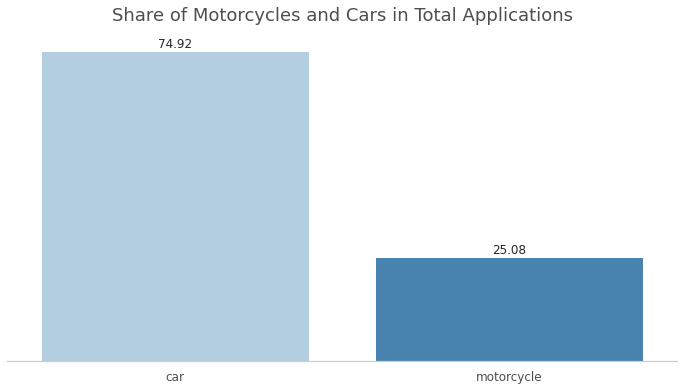

In [10]:
query = """
        select vehicle_type, round(count(*) * 100.0 / (select count(*) from applications), 2) as percentage_of_total
        from applications
        group by 1

        """
share = pd.read_sql(query, conn)
bar_plot(x='vehicle_type', y='percentage_of_total', df=share, title='Share of Motorcycles and Cars in Total Applications')

Seems that cars are three times more demanded than motorcycles.

#### Question 4. Which product(s) could be no longer used, why?

I believe this question can be answered in a few ways.  
The first would be looking at the percent of applications that were not cancelled for each product (the same would be to look at percent cancelled). The query belows returns each product and its active and cancelled applications. We can see below that "product15" has only 0.33% of not cancelled applications (only one out of 303 was not cancelled), which obviously says that this product cannot longer be used. The similiar situation is with products 7 and 6 (4.87% and 8.50% respectively). Here, however, I cannot say with a certainty if these products should be no longer useed because it depends on the returns. Maybe even if only one in twenty applications is not cancelled (as it is the case for "product7") it gives company enough profit to keep it supplied. 

In [47]:
query = """
        select t1.product, t1.cancelled cancelled, t2.active active, 
        round((cast(active as float) / cast(total as float)) * 100, 2) as percent_not_cancelled
        from (
              select product,  count(*) as cancelled
              from applications
              where application_status  = 'Cancelled' 
              group by 1) t1
        inner join (
              select product,  count(*) as active
              from applications
              where application_status  != 'Cancelled' 
              group by 1) t2
        on t1.product = t2.product
        inner join (
              select product,  count(*) as total
              from applications
              group by 1) t3
        on t2.product = t3.product
        order by percent_not_cancelled
        """

pd.read_sql(query, conn)

,product,cancelled,active,percent_not_cancelled
0,Product15,303,1,0.33
1,Product7,6566,336,4.87
2,Product6,7696,715,8.50
3,Product14,343,87,20.23
4,Product1,110,53,32.52
5,Product2,88,47,34.81
6,Product13,65,82,55.78
7,Product8,3,5,62.50
8,Product9,5,11,68.75
9,Product12,19,58,75.32


Another way would be just to check how many active applications each product has. Here again "product15" wins as the worst one. "product17" and "product8" also have only few active applications, but here again it is difficult to say if these product are really unprofitable.

In [48]:
query = """
          select product,  count(*) as active
          from applications
          where application_status  != 'Cancelled' 
          group by 1
          order by 2 
        """

pd.read_sql(query, conn)

,product,active
0,Product15,1
1,Product17,3
2,Product8,5
3,Product9,11
4,Product2,47
5,Product1,53
6,Product12,58
7,Product13,82
8,Product14,87
9,Product19,298


And the third way to answer this question could be to look at the change of applications created for each product during the whole perod of time. If a clear downward trend would be visible for any product, it might indicate the decrease in popularity and thus the need of giving the product up.  
Below all the products ant their applications created are plotted. The grapth looks a bit messy but it can be seen that there is no clear downward trend for any product. Only the products whose lines are basically x axis might suggest they are not popular, but here again it depends on profitability. 


In [50]:
query = """
        select product, strftime('%Y-%m-%d', application_created) as date, count(*) num_applicatons 
        from applications
        group by 1, 2
        """
num_applications = pd.read_sql(query, conn)
num_applications

,product,date,num_applicatons
0,Product1,2019-05-03,1
1,Product1,2019-05-04,7
2,Product1,2019-05-05,8
3,Product1,2019-05-06,2
4,Product1,2019-05-07,3
...,...,...,...
502,Product9,2019-05-24,1
503,Product9,2019-06-02,1
504,Product9,2019-06-03,1
505,Product9,2019-06-10,1


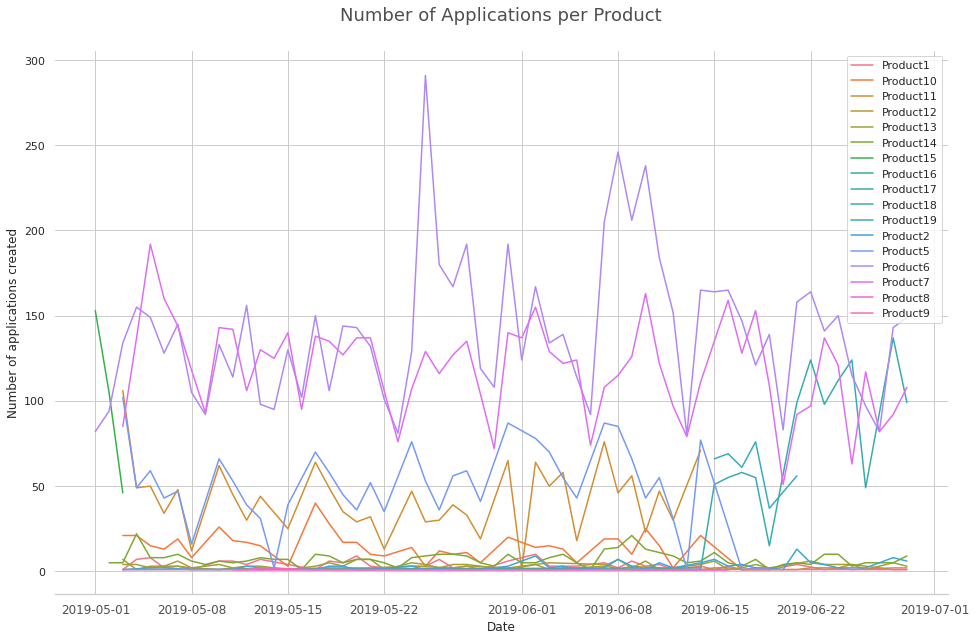

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
num_applications['date'] = pd.to_datetime(num_applications['date'])

plt.figure(figsize=(16, 10))
sns.lineplot(x="date", y="num_applicatons", hue="product", data=num_applications)
sns.set(style="whitegrid")
plt.title("Number of Applications per Product", size=18, 
          color='#4f4e4e', pad=30)
plt.xlabel('Date')
plt.ylabel('Number of applications created')
plt.xticks(size=12, color='#4f4e4e')
legend = plt.legend(title = "")
sns.despine(left=True)

#### Question 5. How many loans each operator issued week over week? Any comments?

In [56]:
query = """
        select operator, count(*) num_applications, strftime('%W', loan_issued) as week
        from applications
        where loan_issued != 'None'
        group by 1, 3
        order by 3
        """
operators = pd.read_sql(query, conn)
operators

,operator,num_applications,week
0,Grace,75,17
1,Leonard,45,17
2,Liliam,70,17
3,Mary,29,17
4,Patricia,82,17
...,...,...,...
71,Leonard,1,29
72,Liliam,1,29
73,Patricia,2,29
74,Liliam,1,30


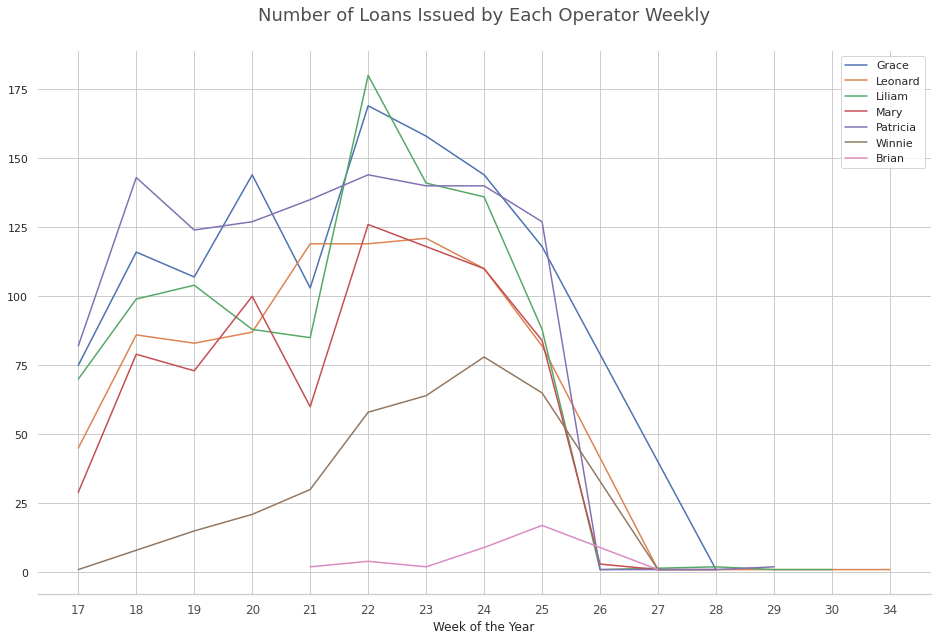

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.lineplot(x="week", y="num_applications", hue="operator", data=operators)
sns.set(style="whitegrid")
plt.title("Number of Loans Issued by Each Operator Weekly", size=18, 
          color='#4f4e4e', pad=30)
plt.xlabel('Week of the Year')
plt.ylabel('')
plt.xticks(size=12, color='#4f4e4e')
legend = plt.legend(title = "")
sns.despine(left=True)

We can see that the pattern of loans issued by all the operators follows the same pattern - the growth at the first part of the period and decline during the second, which started around June of 2019. Loans issued reached basically zero at around 26th week of the year which is the middle if July.  
Grace, Patricia and Liam issued most of the loans while Winnie and Brian issued least of the team (seems that Brian  joined the team latter). Total numbers of loans issued by each operator can be seen below.  
I have also tried to think about the reason this sharp decrease happend but I did not manage to do that. First idea vas Covid-19, but it actually started at the end of the year, so it cannot be the case here. 

In [32]:
query = """
        select operator, count(*) num_loans_issued
        from applications
        where application_status = "Loan issued"
        group by 1
        order by 2 desc
        """
num_loans = pd.read_sql(query, conn)
num_loans

,operator,num_loans_issued
0,Patricia,1166
1,Grace,1135
2,Liliam,996
3,Leonard,856
4,Mary,784
5,Winnie,341
6,Brian,35


Talking about the loans, we can also see the total number of loans issued by the day of the week. It is interesting that on Thursdays almost no loans were issued.

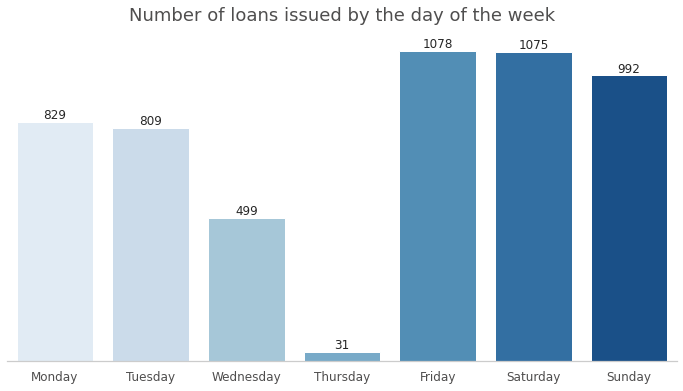

In [58]:
query = """
        select count(*) num_applications,
        case cast (strftime('%w', loan_issued) as integer)
                  when 0 then 'Sunday'
                  when 1 then 'Monday'
                  when 2 then 'Tuesday'
                  when 3 then 'Wednesday'
                  when 4 then 'Thursday'
                  when 5 then 'Friday'
                  else 'Saturday' end as day_of_week
        from applications
        where application_status = "Loan issued"
        group by day_of_week
        order by 
            case
                when day_of_week = 'Monday' then 1
                when day_of_week = 'Tuesday' then 2
                when day_of_week = 'Wednesday' then 3
                when day_of_week = 'Thursday' then 4
                when day_of_week = 'Friday' then 5
                when day_of_week = 'Saturday' then 6
                when day_of_week = 'Sunday' then 7
            end asc
        """
num_reviews_week = pd.read_sql(query, conn)
bar_plot(x='day_of_week', y='num_applications', df=num_reviews_week, title='Number of loans issued by the day of the week')

#### Question 6. Please make a schedule on (calculate) how many repayments are expected for each month (assuming the client will pay according to his schedule).

First step to answer this question is to modify data a bit. Given SQLite does not have an easy way to add number of weeks to the date, I convert weeks to days.

In [177]:

query = """
        select loan_issued, term_unit, term_value,
        (case
          when term_unit = 'day' then date(loan_issued, '+' || cast(term_value as varchar) || ' days')
          else date(loan_issued, '+' || cast(term_value as varchar) || ' months')
          end) as repayment_date
        from(
        select application_status, loan_issued,
          (CASE
            when term_unit = 'week' then term_value*7
            else term_value
          end) as term_value,
          (CASE
            when term_unit = 'week' then 'day'
            else term_unit end) as term_unit
          from applications
          where application_status = 'Loan issued'
          )
        """

pd.read_sql(query, conn)


,loan_issued,term_unit,term_value,repayment_date
0,2019-05-04 12:35:57,day,455,2020-08-01
1,2019-06-25 16:57:30,day,546,2020-12-22
2,2019-05-10 17:16:37,day,364,2020-05-08
3,2019-05-12 09:29:35,month,60,2024-05-12
4,2019-05-04 08:09:14,day,350,2020-04-18
...,...,...,...,...
5308,2019-07-26 15:46:46,month,36,2022-07-26
5309,2019-09-01 11:49:00,month,18,2021-03-01
5310,2019-07-30 17:58:43,month,36,2022-07-30
5311,2019-07-27 16:51:32,month,60,2024-07-27


Having this table above we can get a schedule of repayments easily by adding number of term days/months to the loan issue date and then counting for each month. The result can be seen below. 

In [41]:
query = """
        select strftime('%Y-%m', repayment_date) as repayment_month, count(*) number_of_repayments
        from(
            select loan_issued, term_unit, term_value,
            (case
                when term_unit = 'day' then date(loan_issued, '+' || cast(term_value as varchar) || ' days')
                else date(loan_issued, '+' || cast(term_value as varchar) || ' months')
              end) as repayment_date
            from(
                select application_status, loan_issued,
                  (case
                      when term_unit = 'week' then term_value*7
                      else term_value
                  end) as term_value,
                  (case
                      when term_unit = 'week' then 'day'
                      else term_unit 
                    end) as term_unit
                from applications
                where application_status = 'Loan issued'
                )
            )
        group by 1
        """

schedule = pd.read_sql(query, conn)
schedule

,repayment_month,number_of_repayments
0,2019-09,1
1,2019-11,11
2,2019-12,8
3,2020-01,1
4,2020-03,1
5,2020-04,4
6,2020-05,374
7,2020-06,421
8,2020-07,16
9,2020-08,221


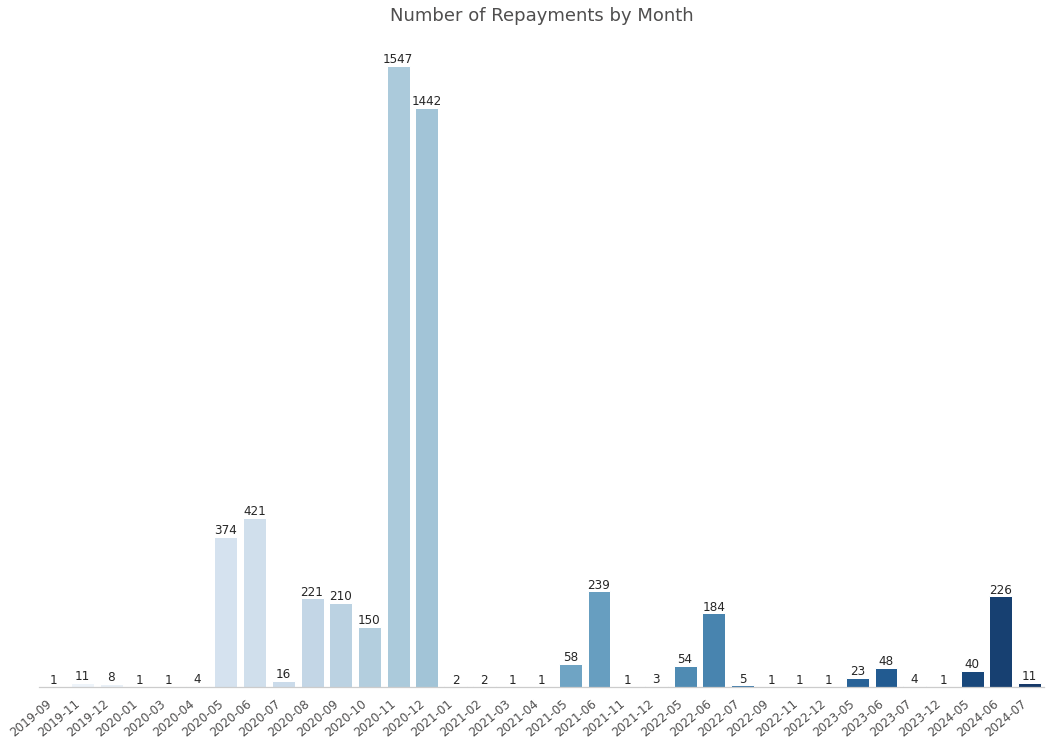

In [40]:
plt.figure(figsize=(18, 12))
splot = sns.barplot(x='repayment_month', y='number_of_repayments', data=schedule, palette='Blues')
splot.bar_label(splot.containers[0])
sns.set(style="whitegrid")
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Repayments by Month', size=18, color='#4f4e4e', pad=14)
plt.xticks(size=12, color='#4f4e4e', rotation=40, ha='right')
plt.yticks([], [])
sns.despine(left=True)

Its quite interesting that repayments are not coming gradually over the whole period. There are some specific months when most of the loans will be repayed (November-December of 2020) and some month when no or only a few repayments will be made.

#### Question 7. Please graphically show change of loans issued daily (Excel).

I am not sure why this question asks to use Excel, but it is way more convinient to it here. 

In [60]:
query = """
        select count(*) num_loans, strftime('%Y-%m-%d', loan_issued) as date
        from applications
        where application_status = 'Loan issued'
        group by 2
        """
loans_daily = pd.read_sql(query, conn)
loans_daily

,num_loans,date
0,73,2019-05-03
1,122,2019-05-04
2,107,2019-05-05
3,80,2019-05-06
4,95,2019-05-07
...,...,...
65,1,2019-07-25
66,1,2019-07-26
67,1,2019-07-27
68,1,2019-07-30


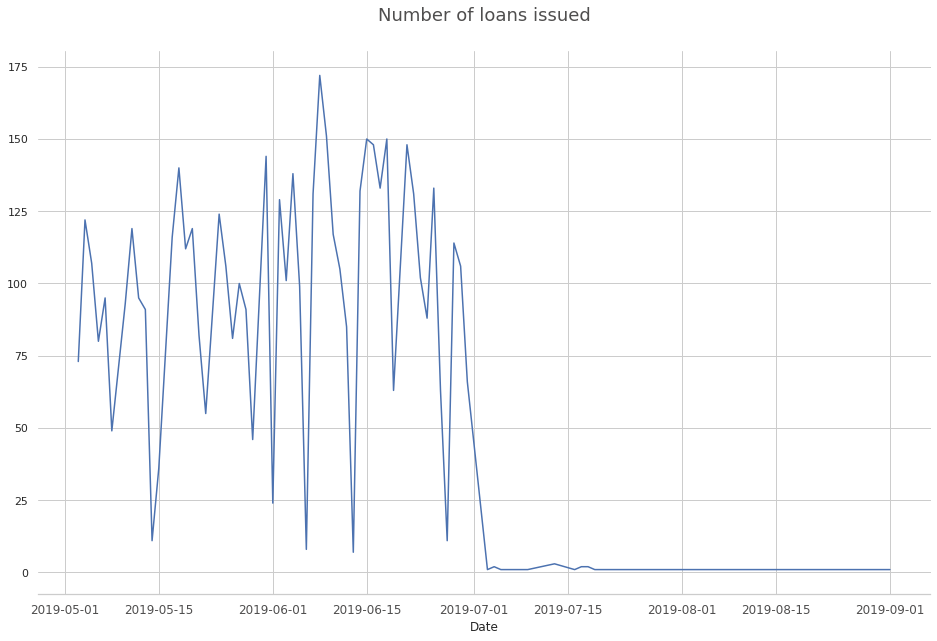

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 10))
loans_daily['date'] = pd.to_datetime(loans_daily['date'])

sns.lineplot(x="date", y="num_loans", data=loans_daily)
sns.set(style="whitegrid")
plt.title("Number of loans issued", size=18, 
          color='#4f4e4e', pad=30)
plt.xlabel('Date')
plt.ylabel('')
plt.xticks(size=12, color='#4f4e4e')
sns.despine(left=True)

The trend is the same we saw comparing operators. This time, however, date is daily so some more detailed volatility can be visible - those seasonal decreases must be Thursdays because we saw litlle loans are issued on this day of the weeek.


### Further Improvements
It would be actually interesting to have data where each change of application status is recorded. It might allow us to see which status is most likely to lead to Cancellation.   
Also, having even more data might allow us to build a model for predicting which application would be cancelled.